# DATA PROCESSING IMPORTS

In [1]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# DEEP LEARNING IMPORTS

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                     Dropout, BatchNormalization, GlobalAveragePooling2D,
                                     Activation, Input, Concatenate)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


2025-12-13 18:49:42.518476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765651782.909694      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765651783.029300      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Scikit-learn IMPORTS

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, 
                            accuracy_score, precision_recall_fscore_support,
                            roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize

# EXPLORE THE DATA

### READ THE DATA 

In [4]:
folder_path = '/kaggle/input/bangladeshi-banknote-dataset/dataset'

file_names = os.listdir(folder_path)
print(f"Total files in dataset: {len(file_names)}")

numbers_outside = [
    int(re.match(r"^(\d+)", file).group(1)) 
    for file in file_names if re.match(r"^(\d+)", file)
]

unique_numbers_outside = sorted(set(numbers_outside))

df_unique = pd.DataFrame(unique_numbers_outside, columns=["Currency"])
print(df_unique)


Total files in dataset: 70542
   Currency
0         2
1         5
2        10
3        20
4        50
5       100
6       500
7      1000


### Count occurrences of each currency type

In [5]:
currency_types = []
for file in file_names:
    match = re.match(r"^(\d+)\s*\(", file)
    if match:
        currency_types.append(int(match.group(1)))

currency_counts = Counter(currency_types)

df_counts = pd.DataFrame(list(currency_counts.items()), 
                         columns=["Currency Type", "Count"])
df_counts = df_counts.sort_values(by="Currency Type")

print(df_counts)
print(f"Number of Classes: {len(df_counts)}")

   Currency Type  Count
4              2   5105
6              5   6389
1             10   8382
2             20  14188
7             50   9837
0            100   6999
3            500  11927
5           1000   7715
Number of Classes: 8


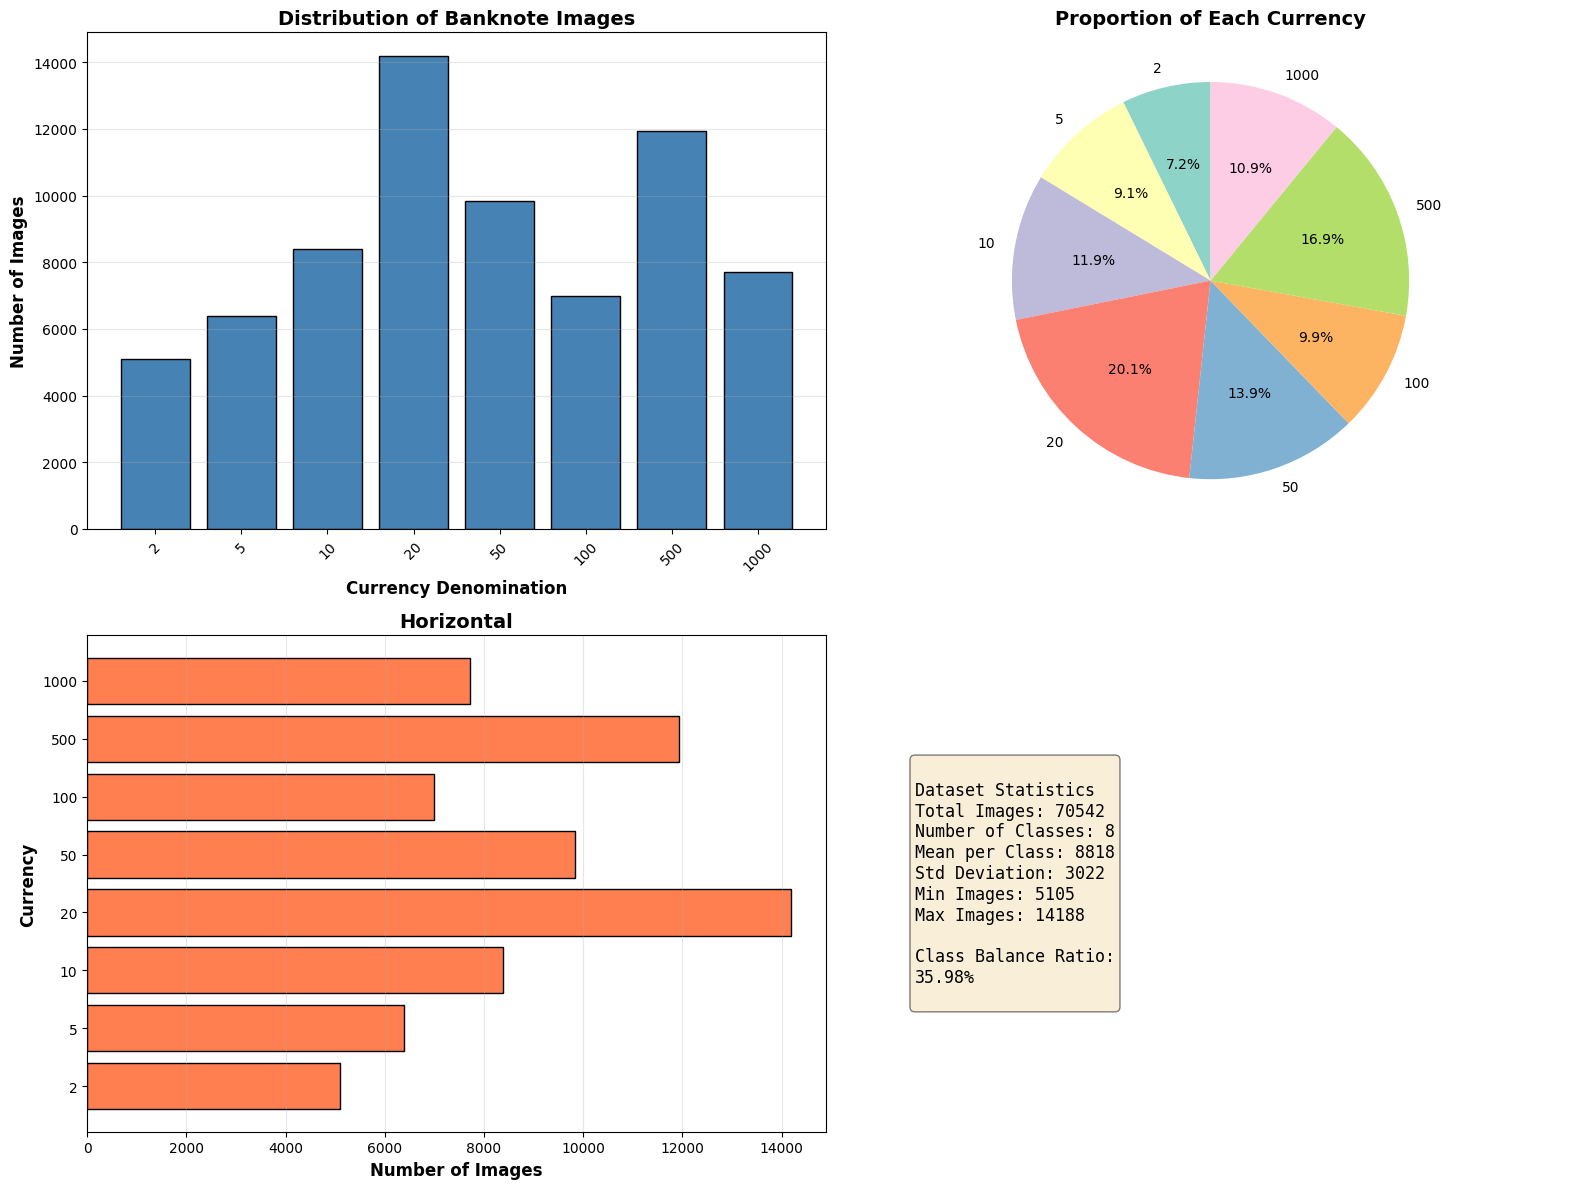

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(df_counts['Currency Type'].astype(str), df_counts['Count'], 
               color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Currency Denomination', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Distribution of Banknote Images', 
                     fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

colors = plt.cm.Set3(range(len(df_counts)))
axes[0, 1].pie(df_counts['Count'], labels=df_counts['Currency Type'], 
               autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 1].set_title('Proportion of Each Currency', 
                     fontsize=14, fontweight='bold')

axes[1, 0].barh(df_counts['Currency Type'].astype(str), df_counts['Count'], 
                color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Number of Images', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Currency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Horizontal', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

stats_text = f"""
Dataset Statistics
Total Images: {df_counts['Count'].sum()}
Number of Classes: {len(df_counts)}
Mean per Class: {df_counts['Count'].mean():.0f}
Std Deviation: {df_counts['Count'].std():.0f}
Min Images: {df_counts['Count'].min()}
Max Images: {df_counts['Count'].max()}

Class Balance Ratio:
{(df_counts['Count'].min() / df_counts['Count'].max()):.2%}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

### Store images for each currency type

In [7]:
currency_images = defaultdict(list)

for file in file_names:
    match = re.match(r"^(\d+)\s*\(", file)
    if match:
        currency_type = int(match.group(1))
        currency_images[currency_type].append(file)

currency_image_lists = dict(currency_images)

for currency, images in sorted(currency_image_lists.items()):
    print(f"Currency {currency}: {len(images)} images")

Currency 2: 5105 images
Currency 5: 6389 images
Currency 10: 8382 images
Currency 20: 14188 images
Currency 50: 9837 images
Currency 100: 6999 images
Currency 500: 11927 images
Currency 1000: 7715 images


### Sample Images from Each Currency Denomination

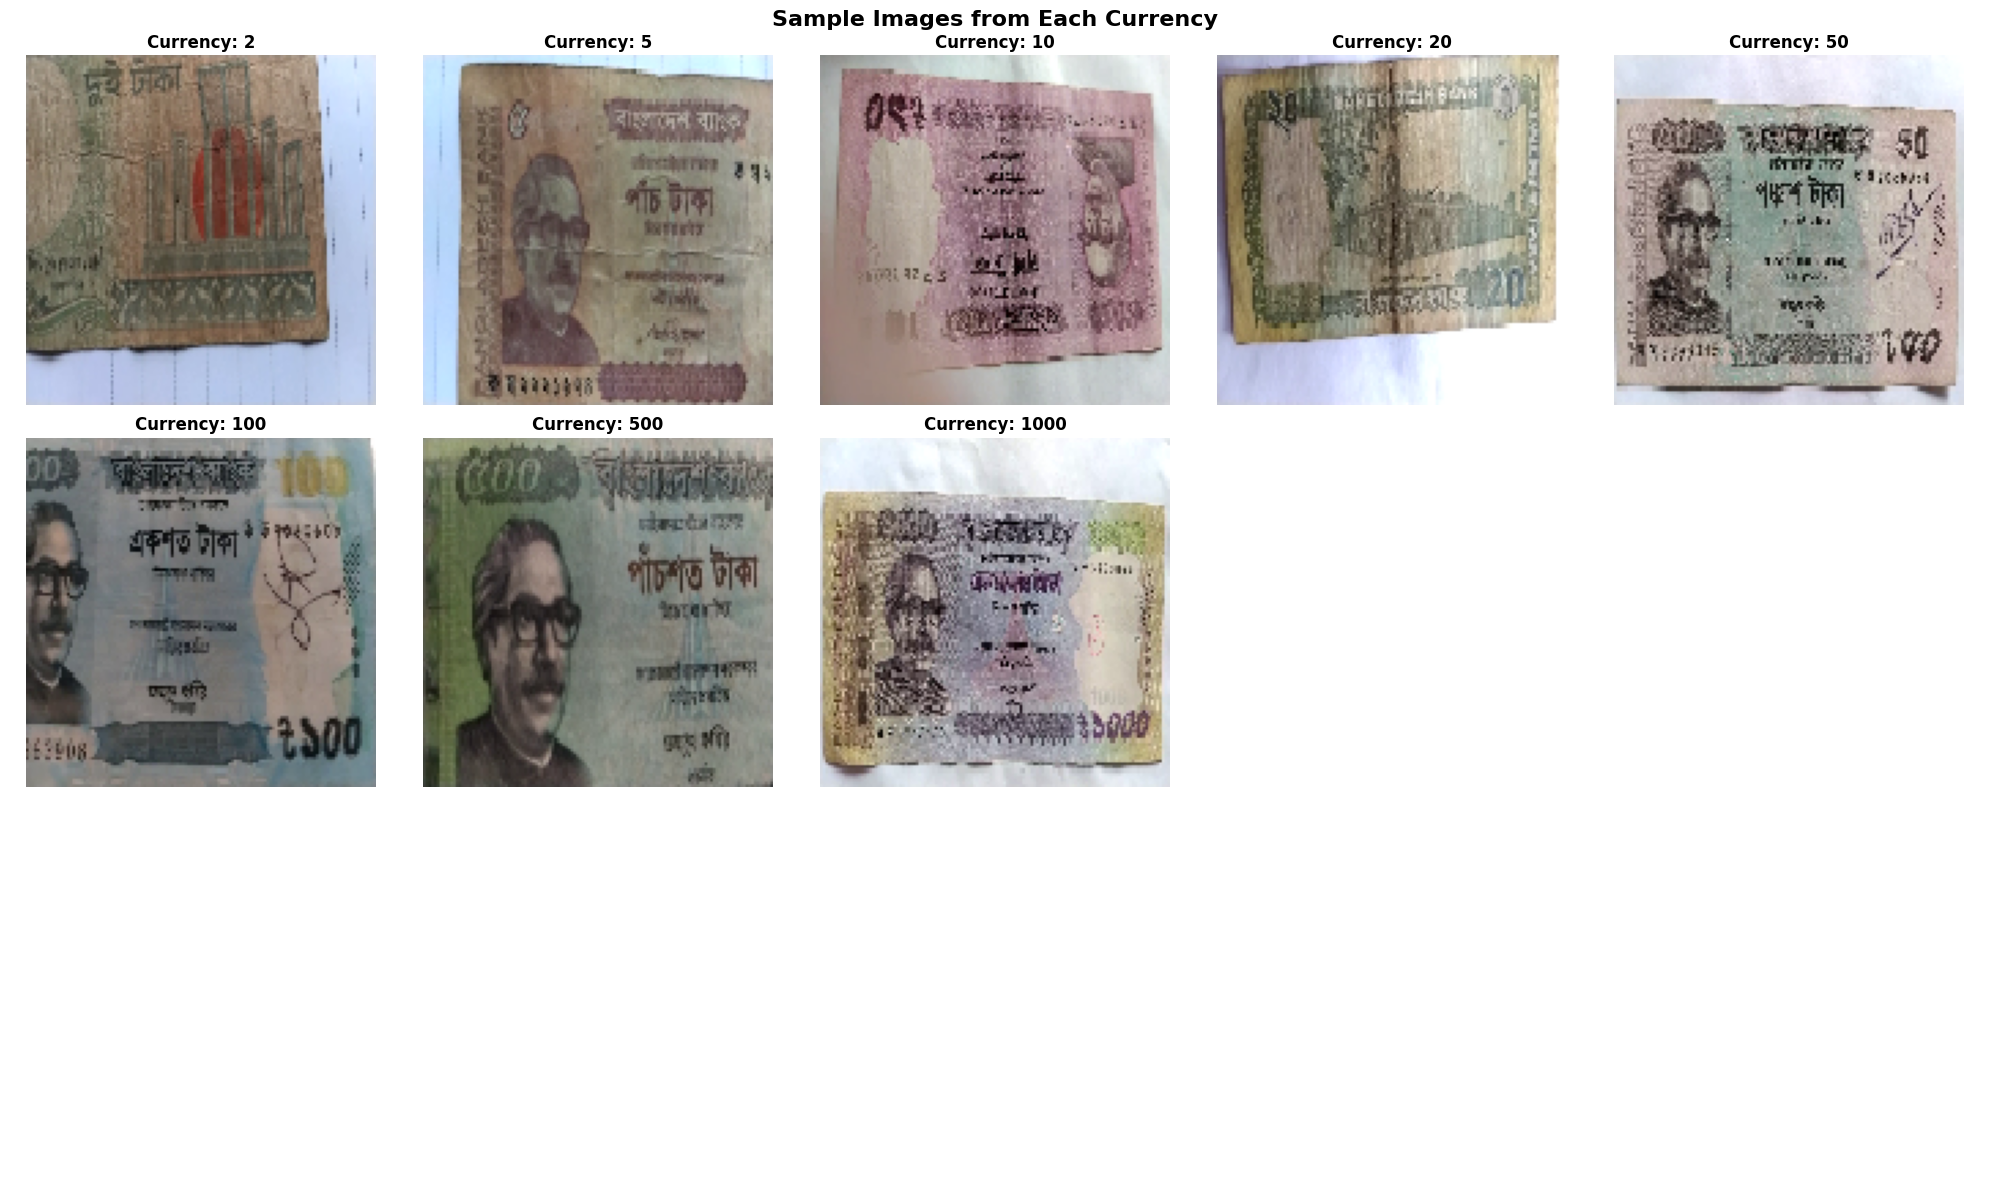

In [8]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.ravel()

idx = 0
for currency in sorted(currency_image_lists.keys()):
    if idx >= 15:
        break
    
    matching_images = currency_image_lists[currency]
    if matching_images:
        img_path = os.path.join(folder_path, matching_images[0])
        img = load_img(img_path, target_size=(128, 128))
        
        axes[idx].imshow(img)
        axes[idx].set_title(f'Currency: {currency}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
        idx += 1

for i in range(idx, 15):
    axes[i].axis('off')

plt.suptitle('Sample Images from Each Currency', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


### Make Dataset balanced

In [9]:
limited_currency_image_lists = {}

for currency, images in currency_image_lists.items():
    if len(images) > 800:
        limited_currency_image_lists[currency] = random.sample(images, 800)
    else:
        limited_currency_image_lists[currency] = images

print("Balanced Dataset:")
for currency, images in sorted(limited_currency_image_lists.items()):
    print(f"Currency {currency}: {len(images)} images")

currency_image_lists = limited_currency_image_lists

Balanced Dataset:
Currency 2: 800 images
Currency 5: 800 images
Currency 10: 800 images
Currency 20: 800 images
Currency 50: 800 images
Currency 100: 800 images
Currency 500: 800 images
Currency 1000: 800 images


# DATA PREPROCESSING

### NORMALIZATION AND SHOW SOME STATISTICS

In [10]:
IMAGE_SIZE = (128, 128)

sample_images_data = []
sample_size = 50

for currency, file_list in currency_image_lists.items():
    for file_name in file_list[:sample_size]:
        img_path = os.path.join(folder_path, file_name)
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img_array = img_to_array(img) / 255.0
        sample_images_data.append({
            'currency': currency,
            'mean': img_array.mean(),
            'std': img_array.std(),
            'min': img_array.min(),
            'max': img_array.max()
        })

df_img_stats = pd.DataFrame(sample_images_data)

print("\nImage Statistics:")
print(df_img_stats.groupby('currency').agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std']
}).round(4))


Image Statistics:
            mean             std        
            mean     std    mean     std
currency                                
2         0.5371  0.0365  0.1888  0.0418
5         0.5432  0.0468  0.1724  0.0345
10        0.5842  0.0409  0.1672  0.0181
20        0.5554  0.0642  0.2002  0.0436
50        0.5388  0.0676  0.1575  0.0314
100       0.5847  0.0556  0.1981  0.0227
500       0.5718  0.0508  0.2108  0.0241
1000      0.5625  0.0796  0.1966  0.0278


### VISUALIZE Mean AND STD pixel VALUES

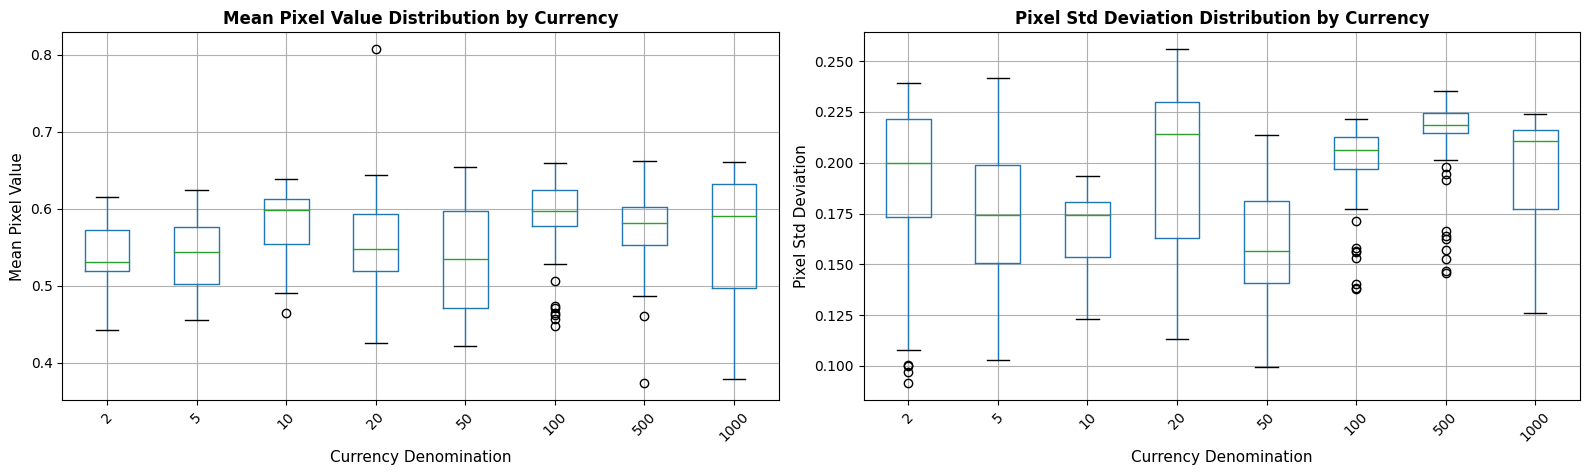

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

df_img_stats.boxplot(column='mean', by='currency', ax=axes[0])
axes[0].set_title('Mean Pixel Value Distribution by Currency', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Currency Denomination', fontsize=11)
axes[0].set_ylabel('Mean Pixel Value', fontsize=11)
plt.sca(axes[0])
plt.xticks(rotation=45)



df_img_stats.boxplot(column='std', by='currency', ax=axes[1])
axes[1].set_title('Pixel Std Deviation Distribution by Currency', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Currency Denomination', fontsize=11)
axes[1].set_ylabel('Pixel Std Deviation', fontsize=11)
plt.sca(axes[1])
plt.xticks(rotation=45)

plt.suptitle('')
plt.tight_layout()
plt.show()


# Load Complete Dataset

In [12]:
images = []
labels = []

for currency, file_list in currency_image_lists.items():
    for i, file_name in enumerate(file_list):
        if i % 500 == 0:
            print(f"Processing currency {currency}: {i}/{len(file_list)}")
        
        image_path = os.path.join(folder_path, file_name)
        image = load_img(image_path, target_size=IMAGE_SIZE)
        image_array = img_to_array(image) / 255.0
        
        images.append(image_array)
        labels.append(int(currency))

images = np.array(images)
labels = np.array(labels)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Processing currency 100: 0/800
Processing currency 100: 500/800
Processing currency 10: 0/800
Processing currency 10: 500/800
Processing currency 20: 0/800
Processing currency 20: 500/800
Processing currency 500: 0/800
Processing currency 500: 500/800
Processing currency 2: 0/800
Processing currency 2: 500/800
Processing currency 1000: 0/800
Processing currency 1000: 500/800
Processing currency 5: 0/800
Processing currency 5: 500/800
Processing currency 50: 0/800
Processing currency 50: 500/800
Images shape: (6400, 128, 128, 3)
Labels shape: (6400,)


# Encoded labels shape

In [13]:
unique_currencies = sorted(np.unique(labels))
currency_to_idx = {curr: idx for idx, curr in enumerate(unique_currencies)}
idx_to_currency = {idx: curr for curr, idx in currency_to_idx.items()}

print("Class Mapping:")
for curr, idx in currency_to_idx.items():
    print(f"Currency {curr} ----> Class {idx}")

labels_encoded = np.array([currency_to_idx[label] for label in labels])

labels_categorical = to_categorical(labels_encoded)
num_classes = len(unique_currencies)

print(f"\nNumber of classes: {num_classes}")
print(f"Encoded labels shape: {labels_categorical.shape}")

Class Mapping:
Currency 2 ----> Class 0
Currency 5 ----> Class 1
Currency 10 ----> Class 2
Currency 20 ----> Class 3
Currency 50 ----> Class 4
Currency 100 ----> Class 5
Currency 500 ----> Class 6
Currency 1000 ----> Class 7

Number of classes: 8
Encoded labels shape: (6400, 8)


# SPLIT THE DATA --> TRAIN , TEST , VAL

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels_categorical, 
    test_size=0.3, 
    random_state=42,
    stratify=labels_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=42,
    stratify=np.argmax(y_temp, axis=1)
)

print(f"Training data: {X_train.shape[0]} images ({X_train.shape[0]/len(images)*100:.1f}%)")
print(f"Validation data: {X_val.shape[0]} images ({X_val.shape[0]/len(images)*100:.1f}%)")
print(f"Test data: {X_test.shape[0]} images ({X_test.shape[0]/len(images)*100:.1f}%)")

Training data: 4480 images (70.0%)
Validation data: 960 images (15.0%)
Test data: 960 images (15.0%)


# Train/Val/Test data distribution

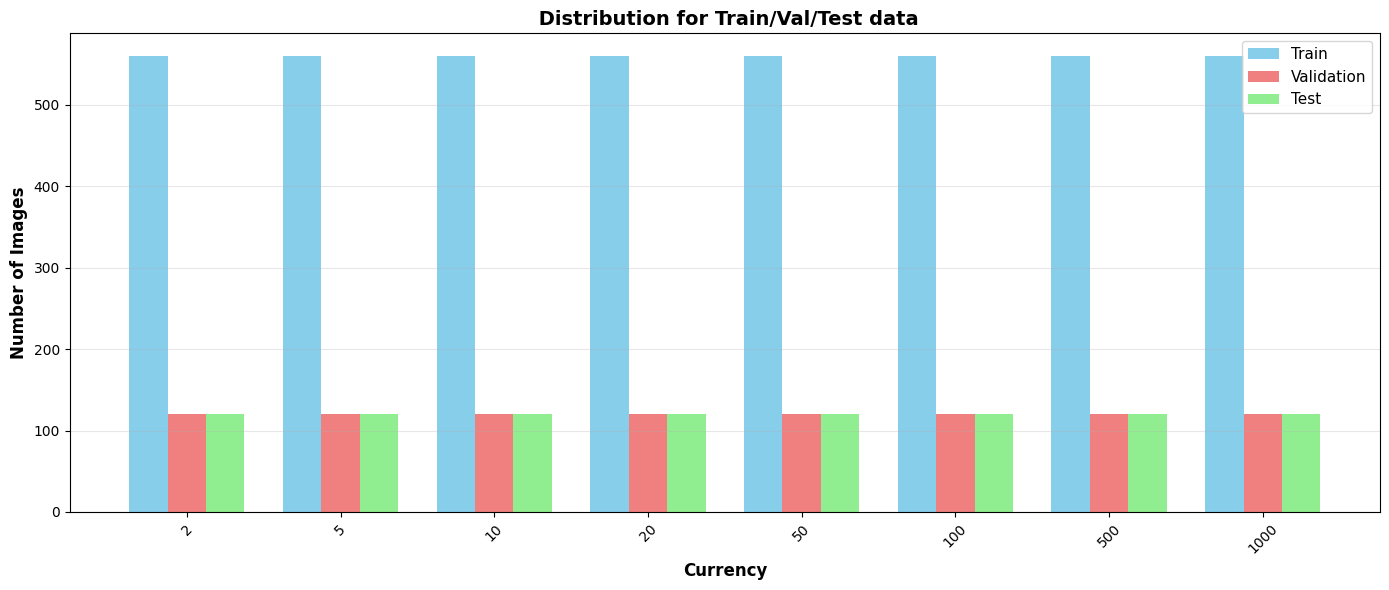

In [15]:
train_dist = pd.Series(np.argmax(y_train, axis=1)).value_counts().sort_index()
val_dist = pd.Series(np.argmax(y_val, axis=1)).value_counts().sort_index()
test_dist = pd.Series(np.argmax(y_test, axis=1)).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(unique_currencies))
width = 0.25

ax.bar(x - width, train_dist.values, width, label='Train', color='skyblue')
ax.bar(x, val_dist.values, width, label='Validation', color='lightcoral')
ax.bar(x + width, test_dist.values, width, label='Test', color='lightgreen')

ax.set_xlabel('Currency', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title(' Distribution for Train/Val/Test data', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([idx_to_currency[i] for i in range(len(unique_currencies))], 
                    rotation=45)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# DATA AUGMENTATION


In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# VISUALIZE SAMPLE OF DATA AFTER AUGMENTATION

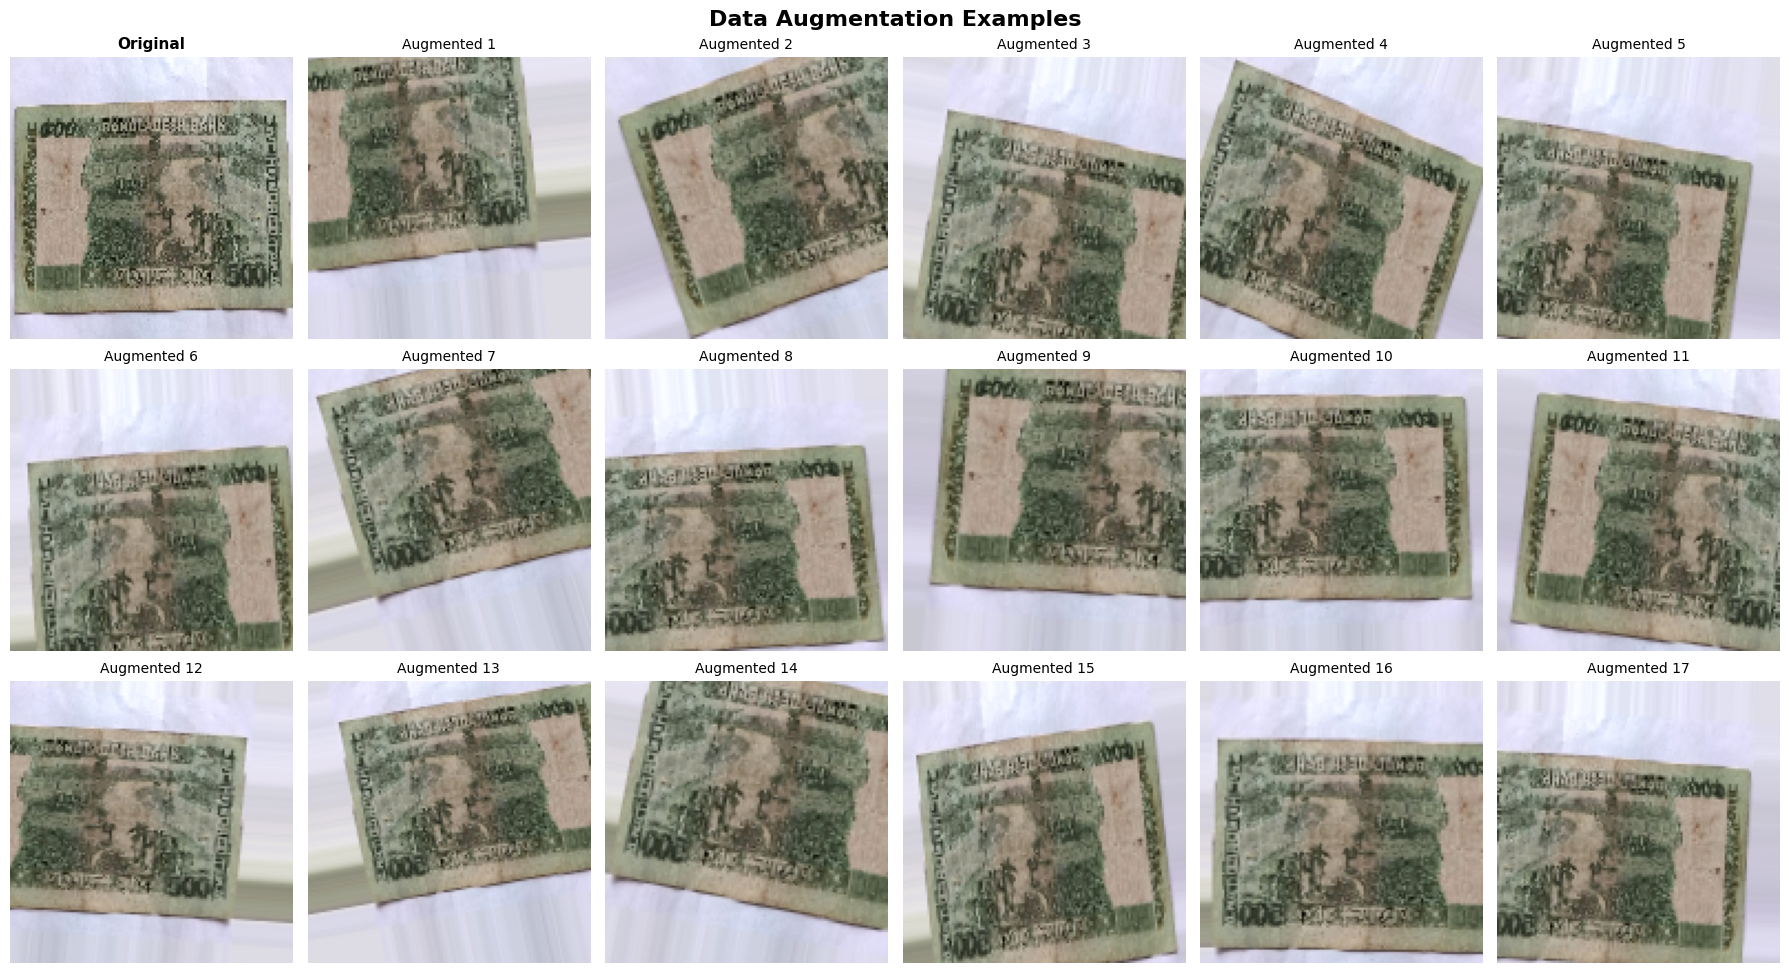

In [17]:
fig, axes = plt.subplots(3, 6, figsize=(18, 10))

sample_img = X_train[0:1]
sample_img_expanded = np.expand_dims(sample_img[0], axis=0)

axes[0, 0].imshow(sample_img[0])
axes[0, 0].set_title('Original', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

aug_iter = train_datagen.flow(sample_img_expanded, batch_size=1)

for i in range(1, 18):
    augmented_img = next(aug_iter)[0]
    row = i // 6
    col = i % 6
    axes[row, col].imshow(augmented_img)
    axes[row, col].set_title(f'Augmented {i}', fontsize=10)
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# BUILD CNN MODEL

In [18]:
def cnn_model(input_shape=(128, 128, 3), num_classes=num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(512),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

model = cnn_model()

model.summary()

I0000 00:00:1765651895.424270      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765651895.424855      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             

 Total params: 9,701,672 (37.01 MB)

 Trainable params: 9,698,216 (37.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

# MODEL COMPILER

In [19]:
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# DEFINE MODEL CALLBACKS [early_stop , reduce_lr , checkpoint]

In [20]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_banknote_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

# TRAIN THE MODEL

In [21]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


I0000 00:00:1765651904.038933     115 service.cc:148] XLA service 0x7ab8ec007660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765651904.040258     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765651904.040279     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765651905.100348     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/140 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.2031 - loss: 2.6341 - precision: 0.3095 - recall: 0.1250 

I0000 00:00:1765651917.679959     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4917 - loss: 1.3786 - precision: 0.6391 - recall: 0.3706
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to best_banknote_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 132ms/step - accuracy: 0.4929 - loss: 1.3753 - precision: 0.6400 - recall: 0.3720 - val_accuracy: 0.1250 - val_loss: 5.9267 - val_precision: 0.1250 - val_recall: 0.1250 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8455 - loss: 0.4221 - precision: 0.8762 - recall: 0.8160
Epoch 2: val_accuracy improved from 0.12500 to 0.18125, saving model to best_banknote_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.8457 - loss: 0.4218 - precision: 0.8763 - recall: 0.8161 - val_accuracy: 0.1813 - val_loss: 5.2135 - val_precision: 0.1887 - val_recall: 0.1813 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9057 - loss: 0.2697 - precision: 0.9210 - recall

# VISUALIZE THE Loss , Accuracy , Precision , Recall FOR THE MODEL 

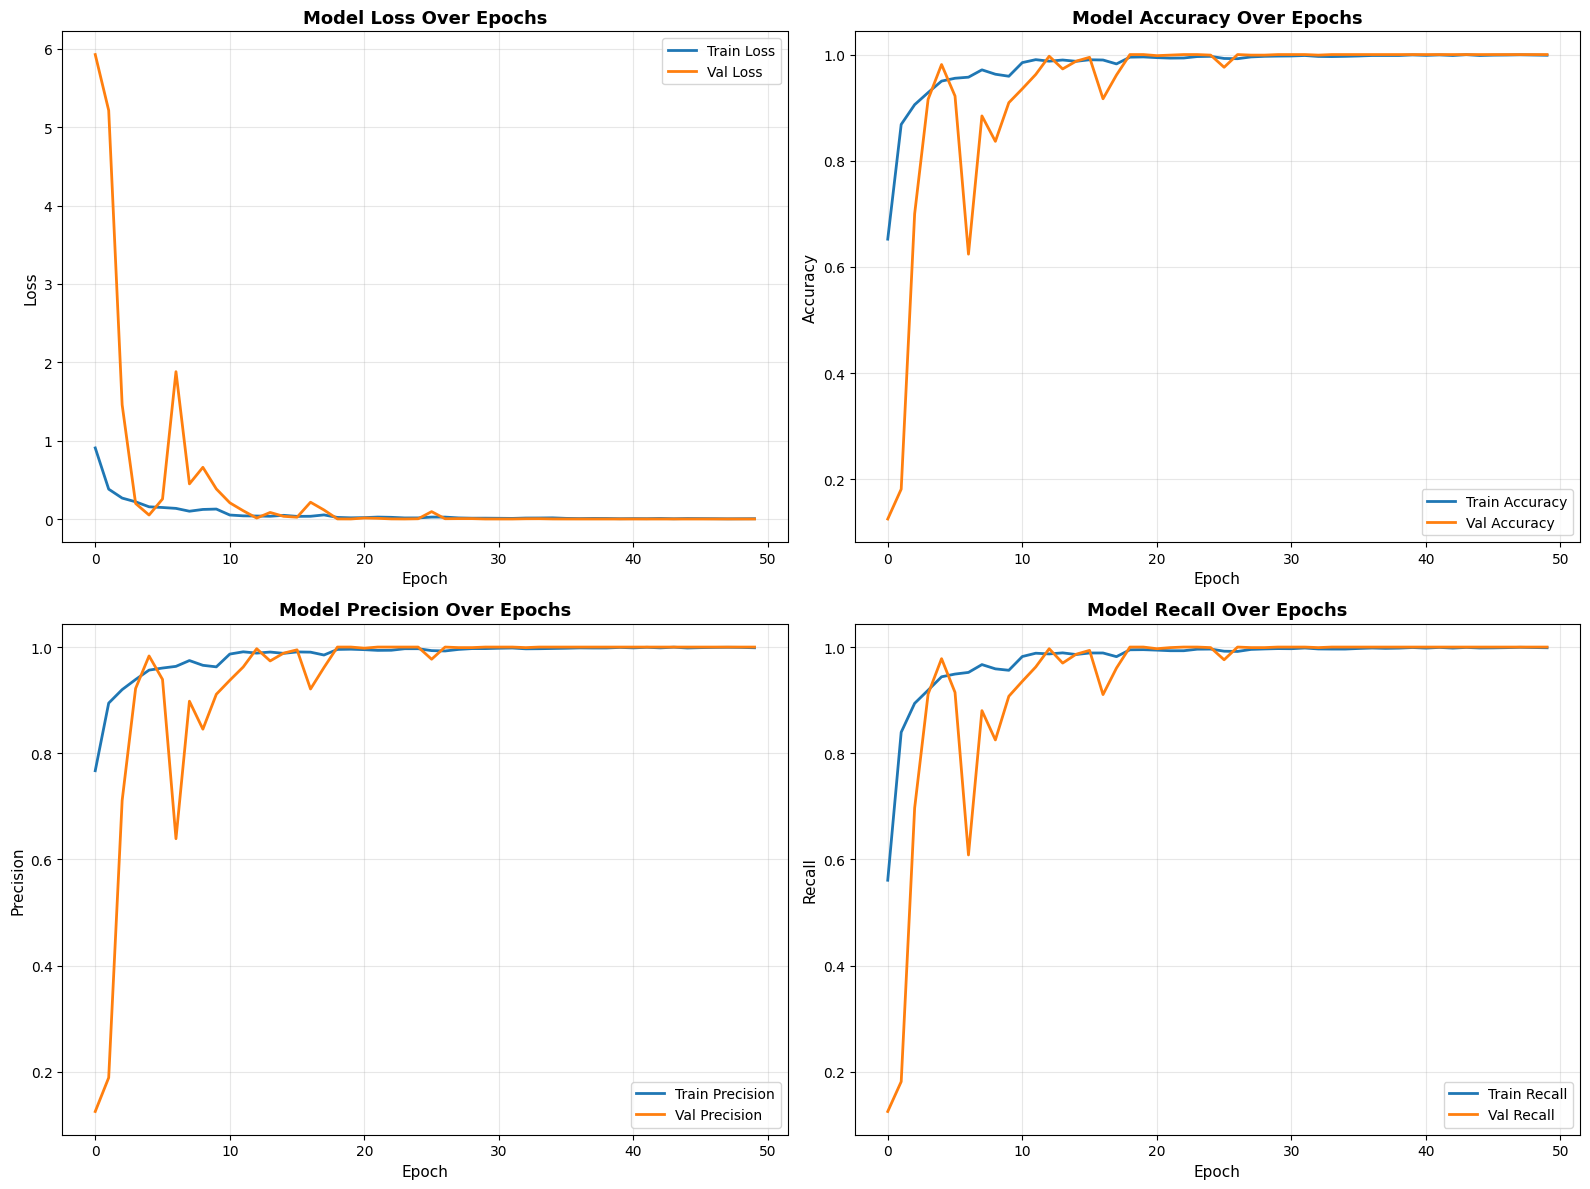

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Model Loss Over Epochs', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy Over Epochs', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision Over Epochs', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Precision', fontsize=11)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Model Recall Over Epochs', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Recall', fontsize=11)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# EVALUATE THE MODEL ON TEST DATA

In [23]:
test_results = model.evaluate(X_test, y_test, verbose=1)

print("TEST SET RESULTS")

print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print("="*60)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.0736e-05 - precision: 1.0000 - recall: 1.0000
TEST SET RESULTS
Test Loss: 0.0000
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000


# GENERATE THE PREDICTIONS OF THE MODEL

In [24]:
y_pred_probs = model.predict(X_test, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


# EVALUATE THE MODEL USING CONFUSION MATRIX (NORMALIZED AND NON NORMALIZED)

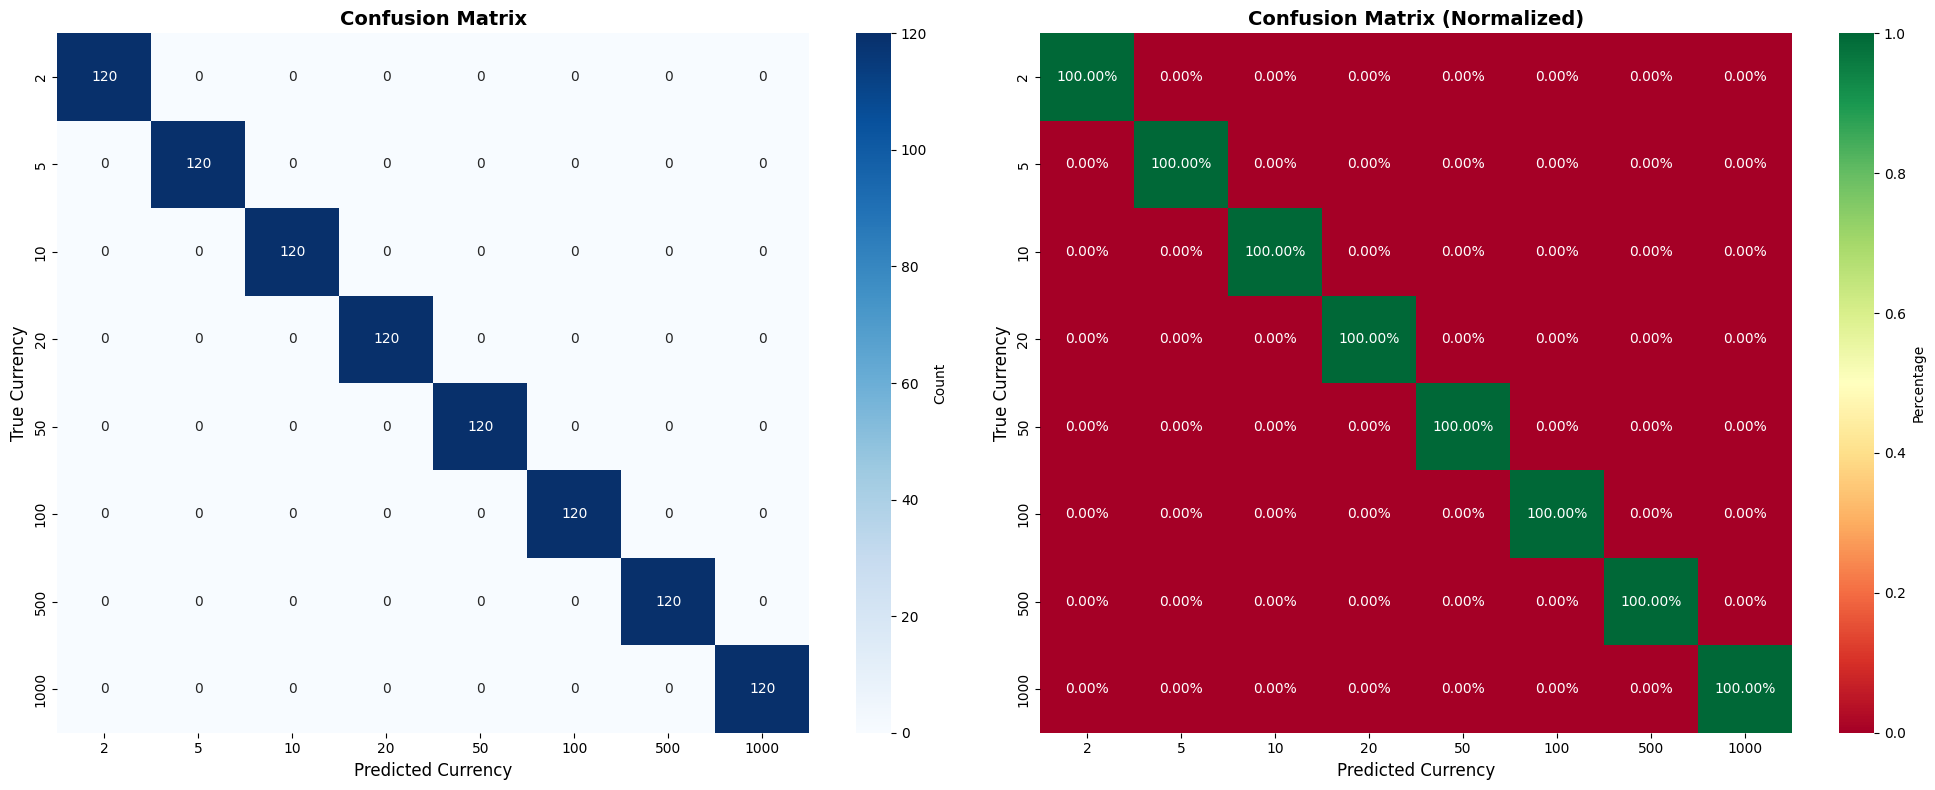

In [25]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[idx_to_currency[i] for i in range(num_classes)],
            yticklabels=[idx_to_currency[i] for i in range(num_classes)],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Currency', fontsize=12)
axes[0].set_ylabel('True Currency', fontsize=12)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[1],
            xticklabels=[idx_to_currency[i] for i in range(num_classes)],
            yticklabels=[idx_to_currency[i] for i in range(num_classes)],
            cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Currency', fontsize=12)
axes[1].set_ylabel('True Currency', fontsize=12)

plt.tight_layout()
plt.show()

# CLASSIFICATION REPORT

In [26]:
class_names = [str(idx_to_currency[i]) for i in range(num_classes)]
report = classification_report(y_true_classes, y_pred_classes, 
                              target_names=class_names, digits=4)


print(report)


              precision    recall  f1-score   support

           2     1.0000    1.0000    1.0000       120
           5     1.0000    1.0000    1.0000       120
          10     1.0000    1.0000    1.0000       120
          20     1.0000    1.0000    1.0000       120
          50     1.0000    1.0000    1.0000       120
         100     1.0000    1.0000    1.0000       120
         500     1.0000    1.0000    1.0000       120
        1000     1.0000    1.0000    1.0000       120

    accuracy                         1.0000       960
   macro avg     1.0000    1.0000    1.0000       960
weighted avg     1.0000    1.0000    1.0000       960



# VISUALIZE THE Precision , Recall , F1-Score 

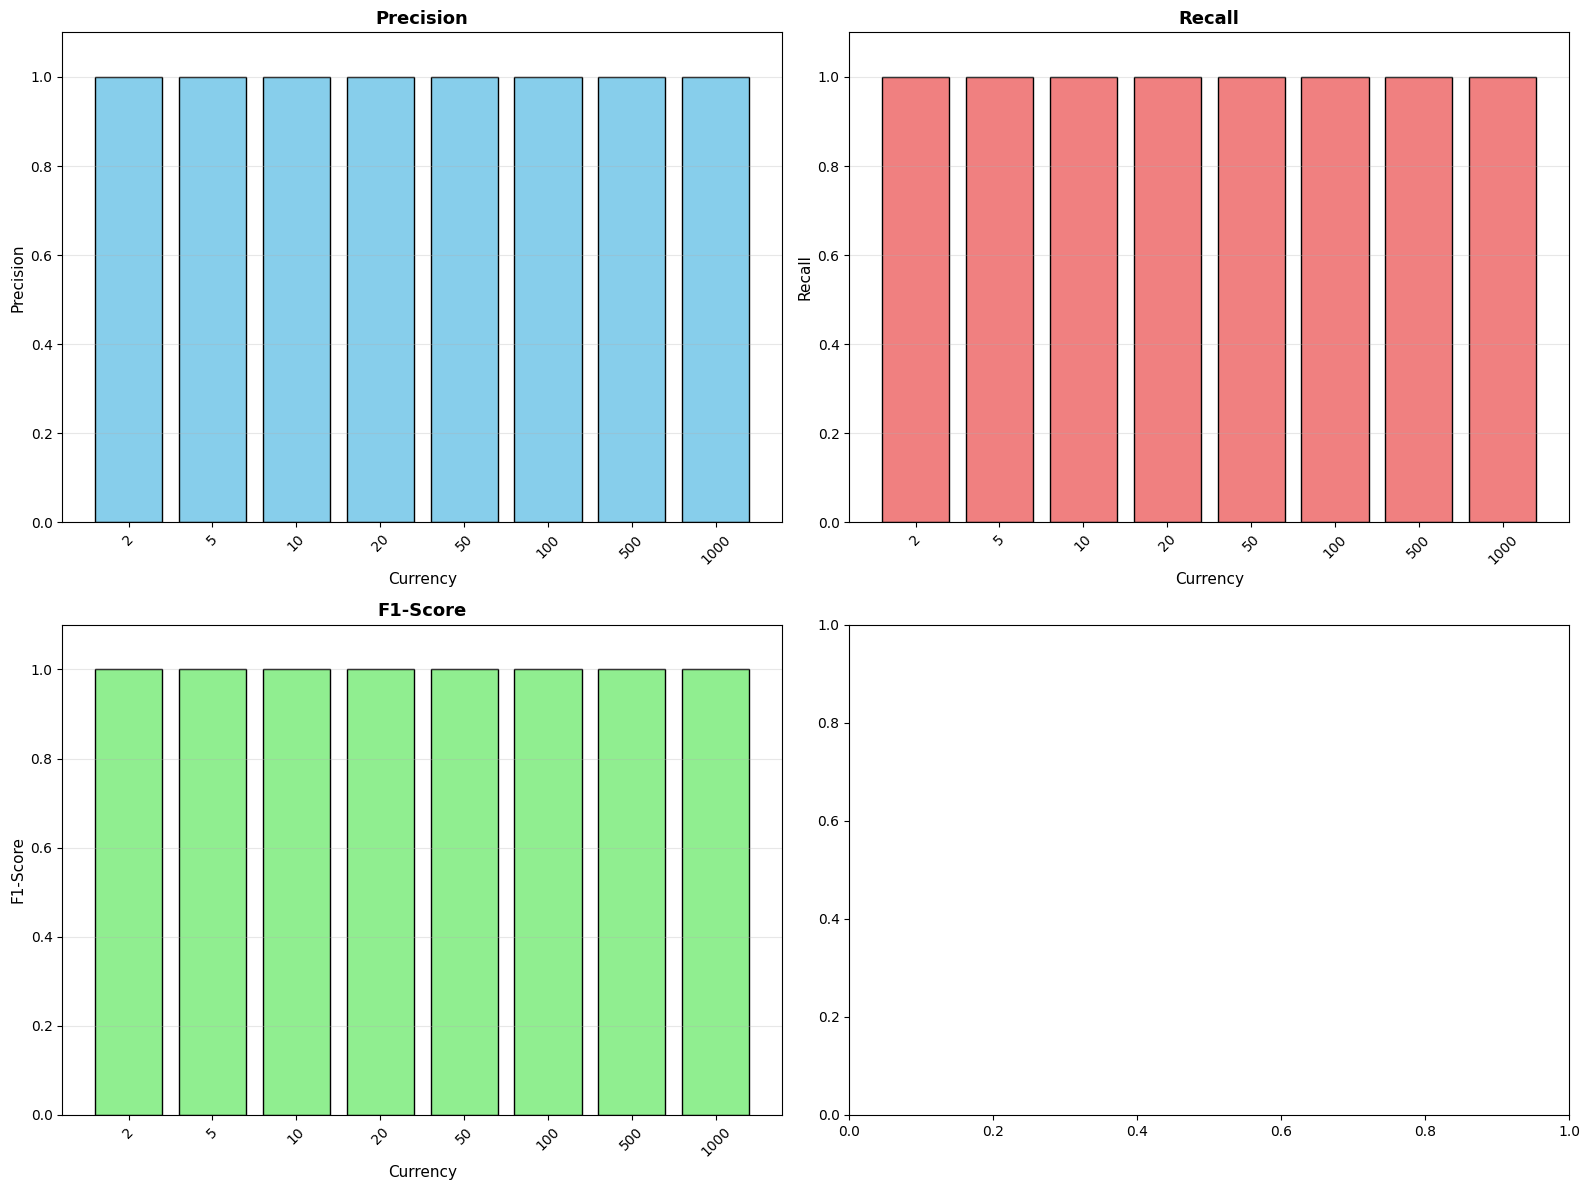

In [27]:
report_dict = classification_report(y_true_classes, y_pred_classes, 
                                   target_names=class_names, 
                                   output_dict=True)

metrics_df = pd.DataFrame(report_dict).transpose()[:-3]  
metrics_df = metrics_df.astype(float)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(range(len(metrics_df)), metrics_df['precision'], 
               color='skyblue', edgecolor='black')
axes[0, 0].set_title('Precision', 
                     fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Currency', fontsize=11)
axes[0, 0].set_ylabel('Precision', fontsize=11)
axes[0, 0].set_xticks(range(len(metrics_df)))
axes[0, 0].set_xticklabels(metrics_df.index, rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 1.1])



axes[0, 1].bar(range(len(metrics_df)), metrics_df['recall'], 
               color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Recall', 
                     fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Currency', fontsize=11)
axes[0, 1].set_ylabel('Recall', fontsize=11)
axes[0, 1].set_xticks(range(len(metrics_df)))
axes[0, 1].set_xticklabels(metrics_df.index, rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].set_ylim([0, 1.1])



axes[1, 0].bar(range(len(metrics_df)), metrics_df['f1-score'], 
               color='lightgreen', edgecolor='black')
axes[1, 0].set_title('F1-Score', 
                     fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Currency', fontsize=11)
axes[1, 0].set_ylabel('F1-Score', fontsize=11)
axes[1, 0].set_xticks(range(len(metrics_df)))
axes[1, 0].set_xticklabels(metrics_df.index, rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([0, 1.1])


plt.tight_layout()
plt.show()

# Get max Confidence

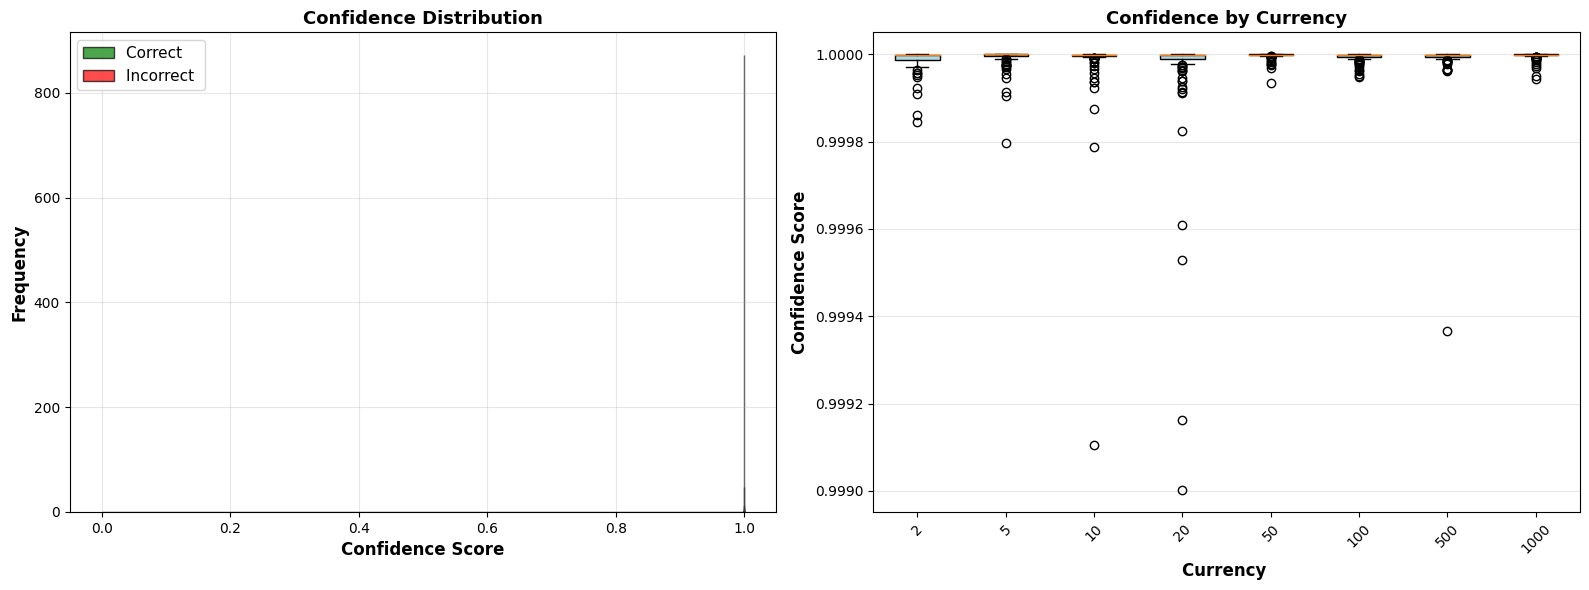

Correct: 1.0000
Incorrect: nan


In [ ]:
confidence_scores = np.max(y_pred_probs, axis=1)
correct_predictions = (y_pred_classes == y_true_classes)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(confidence_scores[correct_predictions], bins=50, alpha=0.7, 
            label='Correct ', color='green', edgecolor='black')
axes[0].hist(confidence_scores[~correct_predictions], bins=50, alpha=0.7, 
            label='Incorrect ', color='red', edgecolor='black')
axes[0].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Confidence Distribution', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

confidence_by_class = []
for i in range(num_classes):
    class_mask = y_true_classes == i
    confidence_by_class.append(confidence_scores[class_mask])

bp = axes[1].boxplot(confidence_by_class, labels=[idx_to_currency[i] 
                                                   for i in range(num_classes)],
                     patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1].set_xlabel('Currency ', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence by Currency', 
                  fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Correct: {confidence_scores[correct_predictions].mean():.4f}")
print(f"Incorrect: {confidence_scores[~correct_predictions].mean():.4f}")


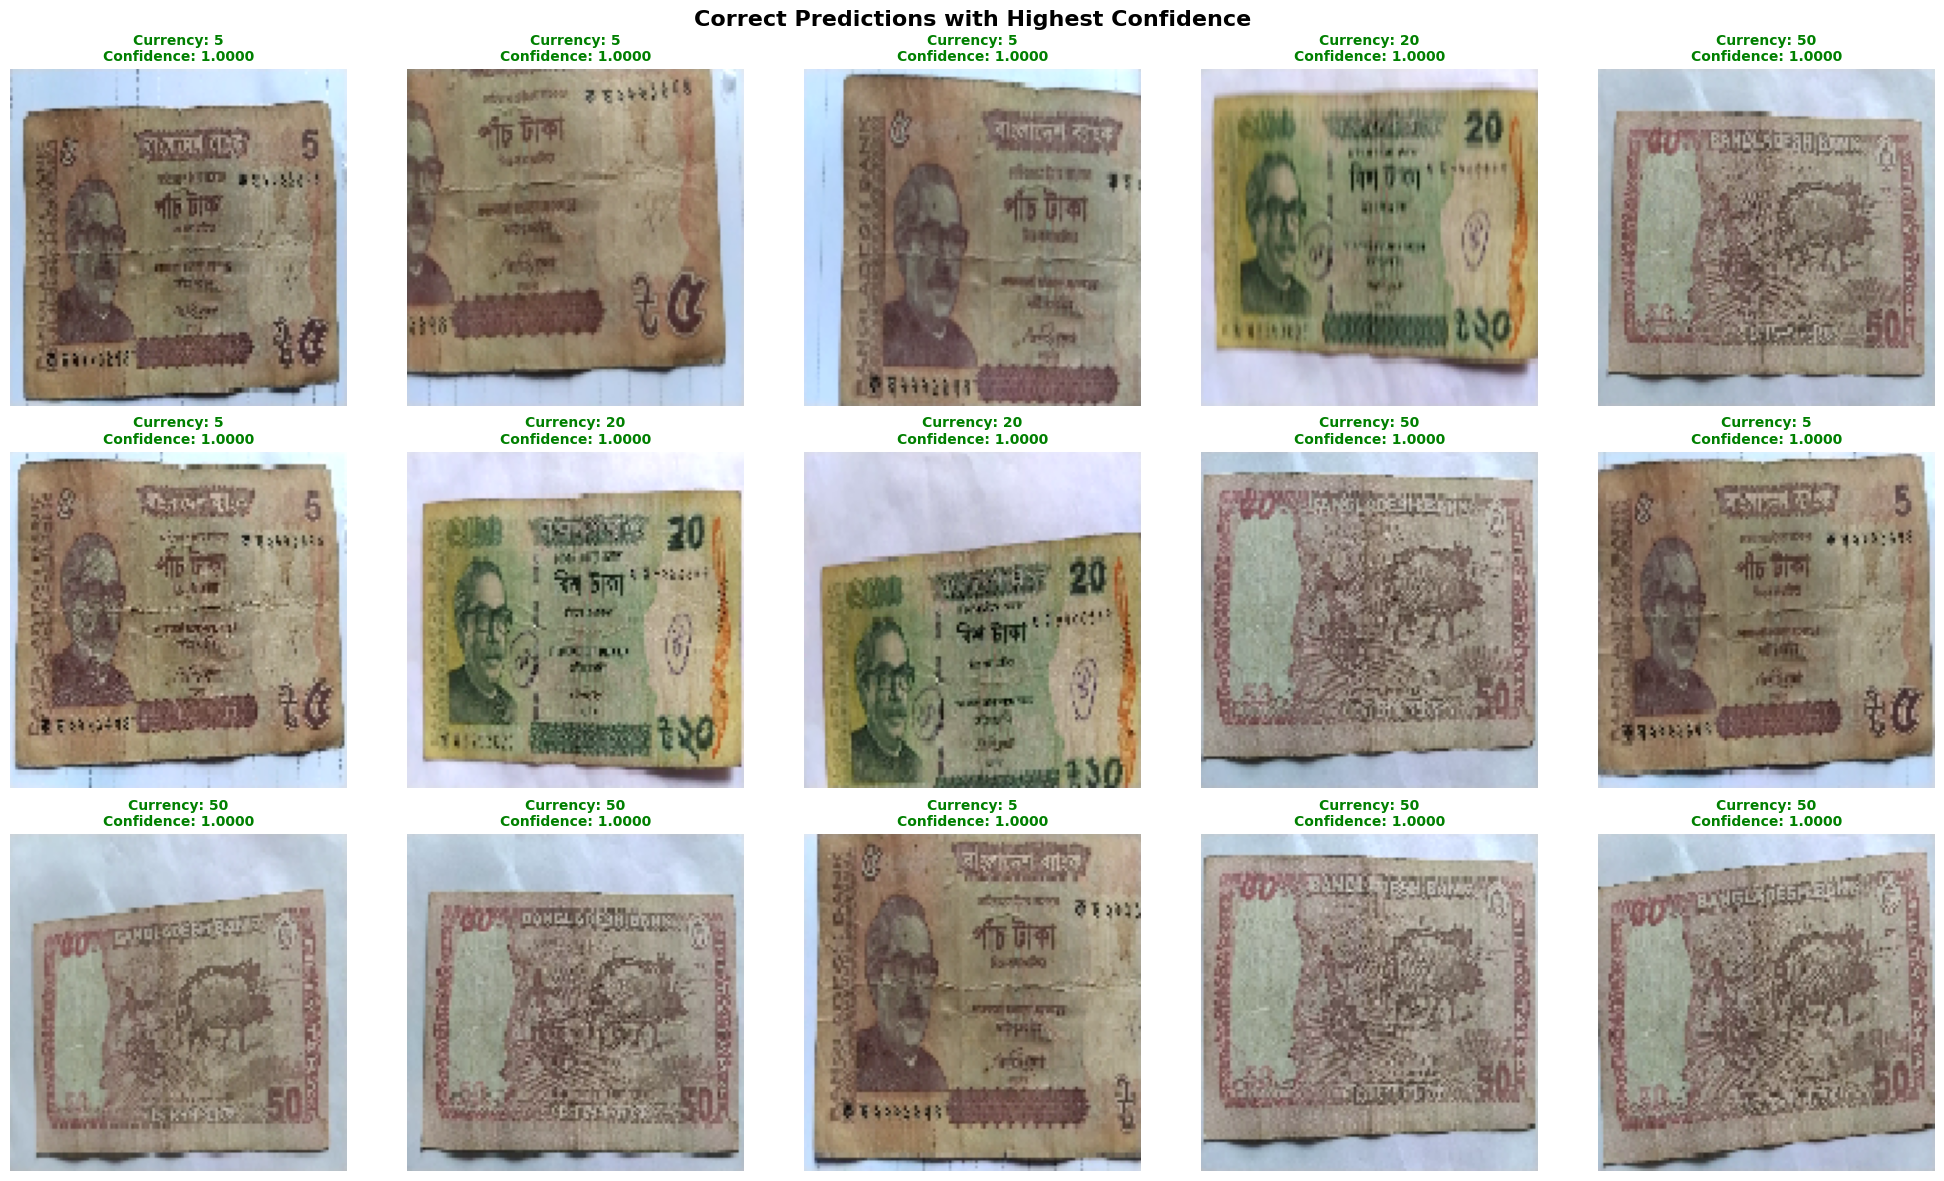

In [29]:
correct_idx = np.where(y_pred_classes == y_true_classes)[0]
high_conf_correct = correct_idx[np.argsort(confidence_scores[correct_idx])[-15:]]

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.ravel()

for i, idx in enumerate(high_conf_correct):
    axes[i].imshow(X_test[idx])
    true_curr = idx_to_currency[y_true_classes[idx]]
    conf = confidence_scores[idx]
    
    axes[i].set_title(f'Currency: {true_curr}\nConfidence: {conf:.4f}', 
                     fontsize=10, color='green', fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Correct Predictions with Highest Confidence', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
model.save('banknote_classifier.keras')